In [ ]:
'''
URJC / GIA / Aprendizaje Automático 1 / Curso 23-24
alfredo.cuesta@urjc.es
'''
import pandas as pd
import numpy as np
from sklearn.preprocessing import add_dummy_feature
from sklearn import linear_model
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize']=(4,4)
np.set_printoptions(precision=2)
pd.set_option("display.precision", 4)

# Máquinas de vectores soporte

Las máquinas de vectores soporte son un modelo que se aprende con una función de pérdida totalmente diferente a lo que hemos visto hasta ahora.

Además introducen un concepto muy potente e importante en ML: las máquinas _Kernel_.

La expresión final con la que se calculan los parámetros óptimos del modelo se obtiene tras mucha manipulación matemática en la que NO vamos a profundizar en tu totalidad, pero sí hasta un punto bastante avanzado.

En concreto, aprenderemos el planteamiento del problema de optimización y como se convierte en otro (_dual_) que es más asequible y que, además, hace posible la utilización de _Kernels_ (de ahí su nombre).

La estructura de este cuaderno es la siguiente:
1. Modelo lineal con márgenes rígidos (_hard_)
2. Modelo lineal con márgenes laxos   (_soft_)
3. Modelo no lineal = máquinas kernel

## Motivación

El siguiente código crea un conjunto de datos de 200 ejemplos, 100 de la clase "+" y 100 de la clase "-"; y 4 clasificadores representados por 4 lineas
- C1, con línea de puntos
- C2, con línea discontinua
- C3, con línea mixta
- C4. con línea continua

Los 4 clasifican correctamente el 100% de los ejemplos del conjunto de datos.

**¿Con cúal te quedarías?**

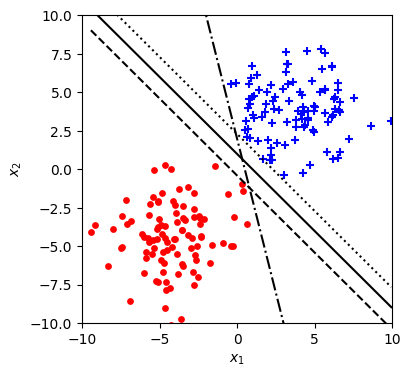

In [ ]:
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt

def plot_dataset(X,y):
  plt.scatter(X[y == 0, 0], X[y == 0, 1],
              c='red', marker='o', s=15, label='Clase 0')
  plt.scatter(X[y == 1, 0], X[y == 1, 1],
              color='blue', marker='+', s=30, label='Clase 1')
  plt.xlabel('$x_1$')
  plt.ylabel('$x_2$')

def plot_clf1(X):
  m = -1.
  b = 2.3
  rangeX = np.linspace(X[:,0].min(),X[:,0].max(),6)
  y = m*rangeX + b
  plt.plot(rangeX,y,'k:')

def plot_clf2(X):
  m = -1.
  b = -0.4
  rangeX = np.linspace(X[:,0].min(),X[:,0].max(),6)
  y = m*rangeX + b
  plt.plot(rangeX,y,'k--')

def plot_clf3(X):
  m = -4
  b = 2
  rangeX = np.linspace(X[:,0].min(),X[:,0].max(),6)
  y = m*rangeX + b
  plt.plot(rangeX,y,'k-.')

def plot_clf4(X):
  m = -1
  b = 1
  rangeX = np.linspace(X[:,0].min(),X[:,0].max(),6)
  y = m*rangeX + b
  plt.plot(rangeX,y,'k')

#- Script de ejecución
n_samples=200
centers = [[-4,-4],[4,4]]
cluster_std = [2,2]
n_features = 2

X, y = make_blobs(n_samples=n_samples,
                  centers=centers,
                  cluster_std=cluster_std,
                  n_features=2,
                  random_state=1460)
plot_dataset(X,y)
plot_clf1(X); plot_clf2(X); plot_clf3(X); plot_clf4(X)
plt.axis([-10,10,-10,10]); plt.show()

Los tres primeros (C1, C2, C3) no tienen prácticamente **margen**, es decir una zona en la que no hay ejemplos de ninguna clase.<br>
Si implementamos y desplegamos cualquiera de ellos en una aplicación real, la probabilidad de que se equivoquen cuando llegue un ejemplo cercano al borde es más alta que si el borde estuviera un poco alejado.

Sin embargo C4 tiene más márgen y por tanto es más robusto a nuevos ejemplos próximos a la superficie de decisión.

**SVM** es una modelo que se crea con el objetivo de **maximizar el margen**.

# Pasos previos
SVM es un modelo para clasificación binaria.

Para modelos lineales esto significa que la superficie de decisión es un hiperplano y los elementos de su vector característico son los parámetros que hemos obtenido a partir del aprendizaje de los datos.

Para toda la explicación vamos a reducir el número de características a dos $(x_1, x_2)$ porque así nos podemos ayudar de figuras para comprenderlo. <br>
Los resultados son generalizables a cualquier dimensión $D$.



## Ecuaciones de la superficie de decisión
El plano separador son todos aquellos puntos que satisfacen la ecuación $w_0 + {\bf w}^\top{\bf x} = 0,~$ que para el caso particular de esta explicación queda:
$$
w_0 + w_1x_1 + w_2x_2 = 0.
$$

Por otro lado, podemos definir el plano separador sobre el plano $\overline{X_1X_2}$ a partir de un punto $(0,b)$ y un vector director $(v_1, v_2)$ con la ecuación
$$
x_2 = \left(\frac{v_2}{v_1}\right)x_1 + b
$$

De las dos expresiones se deduce que:
$$
\left(-b\right) + \left(-\frac{v_2}{v_1}\right)x_1 + \left(1\right)x_2 = 0,
\quad\text{ pero también que}\quad
\left(b\right) + \left(\frac{v_2}{v_1}\right)x_1 + \left(-1\right)x_2 = 0.
$$
De los dos, elegimos el de la izquierda. El motivo se muestra un poco más abajo.

Por último, recordamos que el vector característico del plano separador son los coeficientes $(w_1, w_2).$

Todo ello se puede ver en el siguiente código, que:
- dibuja una recta en el plano $\overline{X_1X_2}$ definida por un vector director y con un punto de intercepción elegido por nosotros.
- dibuja el vector director, el punto de intercepción y el vector característico.

El vector director V es: [[ 0.5 -1. ]]
El vector perpendicular a V es: W = [[2. 1.]]
El punto de intercepción b = 2, 
 que da lugar a término independiente w_0 = [-2.]


<ipython-input-3-f3aa86405582>:27: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  plt.arrow(0, b, float(v[0]), float(v[1]),
<ipython-input-3-f3aa86405582>:29: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  plt.arrow(0, b, float(w[1]), float(w[2]),
<ipython-input-3-f3aa86405582>:31: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  plt.arrow(0, 0, float(v[0]), float(v[1]),
<ipython-input-3-f3aa86405582>:33: DeprecationWarning: Conversion of an array with ndim > 0 to a sca

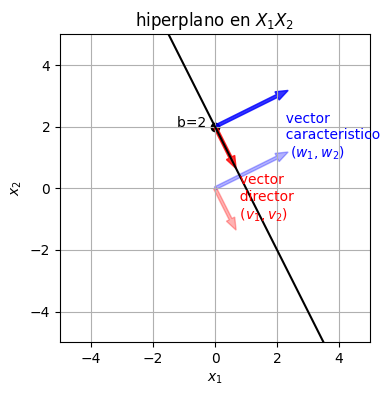

In [ ]:
def hiperplane(X, v, b):
    return b + (v[1]/v[0])*X

bound = 5
Ns = 6
v = [0.5, -1.]
b = 2

#- obtención de los pares (x_1,x_2) que pertenecen al hiperplano
v = np.expand_dims(v , axis=1) #<- conversión a vector columna
x1_clf = np.linspace(-bound,bound,Ns)
x2_clf = hiperplane(x1_clf, v, b)

#- cálculo del vector característico
m = v[1]/v[0]
w = [-b, -m[0], 1.]
w = np.expand_dims(w , axis=1) #<- conversión a vector columna

#- comentario en pantalla
print(f'El vector director V es: {v.T}')
print(f'El vector perpendicular a V es: W = {w[1:].T}')
print(f'El punto de intercepción b = {b}, \n que da lugar a término independiente w_0 = {w[0]}')

#- figura
plt.plot(x1_clf, x2_clf, 'k');
plt.scatter(0,b,c='k')
plt.arrow(0, b, float(v[0]), float(v[1]),
              width=.1, head_length=.4, alpha=0.8, color='r' )
plt.arrow(0, b, float(w[1]), float(w[2]),
              width=.1, head_length=.4, alpha=0.8, color='b' )
plt.arrow(0, 0, float(v[0]), float(v[1]),
              width=.1, head_length=.4, alpha=0.3, color='r' )
plt.arrow(0, 0, float(w[1]), float(w[2]),
              width=.1, head_length=.4, alpha=0.3, color='b' )

plt.text(0, b, f'b={b}  ', horizontalalignment='right')
plt.text(v[0], v[1], f'  vector\n  director\n  $(v_1,v_2)$', c='red')
plt.text(w[1], w[2], f'  vector\n  caracteristico\n   $(w_1,w_2)$', c='blue')

plt.xlabel('$x_1$'); plt.ylabel('$x_2$'); plt.title('hiperplano en $X_1X_2$')
plt.axis([-bound,bound,-bound,bound]); plt.grid(); plt.show()

Como sabemos, la clase $+$ se asigna a un ejemplo $\bf x$ cuando $f({\bf x},{\bf w}) = w_0 + w_1x_1 + w_2x_2 > 0$.

Entonces, de las dos posibilidades, elegimos aquella que deje la clase $+$ "encima" del hiperplano clasificador. <br>
Esto ocurre en la que estaba más a la izquierda, o sea
$$
w_0 = -b \quad,\quad  w_1 = -\frac{v_2}{v_1} \quad,\quad  w_2 = 1
$$
En el siguiente código se muestra que, efectivamente, la clase positiva es la que queda por "encima" del plano separador.

También podemos ver que el vector característico "apunta" hacia la clase $+$.

El código además muestra otros dos planos paralelos, uno por encima, que corta en $~(b+1)~$ y otro por debajo, que corta en $~(b-1)~$. <br>
Estos planos extra definirán nuestro **margen** en breve.

<ipython-input-4-8c0e25c1e1bd>:24: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  plt.arrow(0, b, float(v[0]), float(v[1]),
<ipython-input-4-8c0e25c1e1bd>:26: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  plt.arrow(0, b, float(w[1]), float(w[2]),


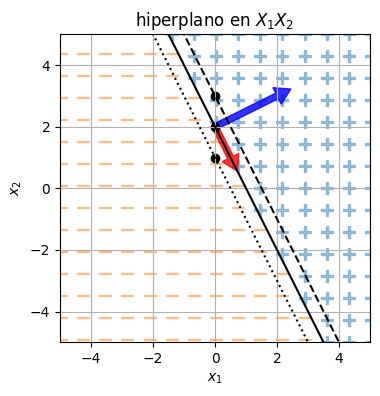

In [ ]:
def classifier(X, w):
    return np.matmul(w[1:].T, X) + w[0]

#- hacemos un barrido del espacio X y probamos con cada par de puntos
#  si el resultado está por encima o por debajo del plano separador
Ns = 15
rangeX0 = np.linspace(-bound, bound, Ns)
rangeX1 = np.linspace(-bound, bound, Ns)
[XX0, XX1] = np.meshgrid(rangeX0, rangeX1)
X0 = np.expand_dims(XX0.ravel(), axis=0)
X1 = np.expand_dims(XX1.ravel(), axis=0)
X = np.vstack((X0,X1))

yhat = classifier(X, w) #<- clasificamos cada punto del barrido

#- Figura
flag_arrows  = True
flag_margins = True

plt.scatter(X0[yhat>0], X1[yhat>0], marker='$+$', s=99, alpha=0.4)
plt.scatter(X0[yhat<0], X1[yhat<0], marker='$-$', s=99, alpha=0.4)

if flag_arrows:
    plt.arrow(0, b, float(v[0]), float(v[1]),
              width=.2, head_length=.5, alpha=0.8, color='r' )
    plt.arrow(0, b, float(w[1]), float(w[2]),
              width=.2, head_length=.5, alpha=0.8, color='b' )

if flag_margins:
    plt.plot(x1_clf, x2_clf,'k')
    plt.plot(rangeX0, hiperplane(rangeX0, v, b+1), '--k')
    plt.plot(rangeX0, hiperplane(rangeX0, v, b-1), ':k')
    plt.scatter([0, 0, 0] ,[b-1, b, b+1],c='k')

plt.xlabel('$x_1$'); plt.ylabel('$x_2$'); plt.title('hiperplano en $X_1X_2$')
plt.axis([-bound,bound,-bound,bound]); plt.grid(); plt.show()

## Distancia del hiperplano al origen

La distancia del plano separador al origen se calcula geométricamente siguiendo los pasos de la figura de abajo.

- Por construcción se deduce que la distancia $~d = b \sin (\gamma)$.
- Para obtener el $\sin(\gamma)$ usamos el vector característico. <br>
  - El vector característico se descompone en su componente horizontal y vertical.
  - Sabemos que la vertical $~w_2 = 1 = \Vert {\bf w} \Vert \sin (\gamma)$.

Por tanto $~ d = \frac{b}{\Vert {\bf w} \Vert}$

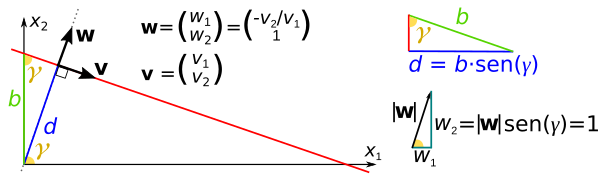

**Importante**
- La distancia $~d~$ NO depende del tamaño de ${\bf v}$.
> Si multiplicamos por una constante a ${\bf v}$ cambiará su tamaño pero no su pendiente respecto del eje horizontal $m = v_2/v_1$. <br>
Precisamente esa inclinación es (con signo menos) la componente horizontal de ${\bf w} = w_1$, y la componente vertical está fija en $w_2=1.$

El siguiente código muestra la distancia al origen del ejemplo que estamos siguiendo.


In [ ]:
print(f'w = {w.T}')
norma_w = np.sqrt( np.matmul(w[1:].T,w[1:]) )
print(f'norma de w = {norma_w}')
d = b/norma_w
print(f'distancia al origen d = {d}')

w = [[-2.  2.  1.]]
norma de w = [[2.24]]
distancia al origen d = [[0.89]]




Puedes probar a modifcar ${\bf v}$ multiplándolo por una constante y verás que la distancia $d$ NO varía.

Por ejemplo, modifica el código de la siguiente manera:

      v = np.expand_dims(v , axis=1) #<- conversión a vector columna
      v = v*4 #<--- AÑADIR esta línea

y luego vuelve a ejecutar todo.

## Márgenes

En SVM el **margen** es la zona interior delimitada por dos superficies paralelas a la superficie de decisión, una por encima y otra por debajo.

Estamos asumiendo el modelo lineal $w_0 + w_1x_1 + w_2x_2$, cuya superficie de separación pasa por el punto $~(0,b).$

Creamos 2 planos paralelos:
- uno por encima, que pase por el punto $~(0, b+1),~$
cuya  distancia al origen es
$d^{(+)} = \frac{b+1}{\Vert {\bf w} \Vert}$.
- otro por debajo, que pase por $~(0, b-1),~$
cuya distancia al origen es
$d^{(-)} = \frac{b-1}{\Vert {\bf w} \Vert}$.

El **margen** $\varepsilon~$ es la distancia que hay entre los dos planos paralelos, es decir:
$$
 \varepsilon = d^{(+)} - d^{(-)} = \frac{b+1 -(b-1)}{\Vert {\bf w}\Vert} = \frac{2}{\Vert{\bf w}\Vert}
$$


El margen $\varepsilon$ CRECE cuando la norma $\Vert\bf w \Vert$ DECRECE

Por tanto, para **maximizar** $\varepsilon$ tenemos que **minimizar** $\Vert\bf w\Vert$.

Y esto implica que el margen depende del modelo, puesto que $~{\bf w}~$ son sus parámetros.

En otras palabras, modificando los parámetros del modelo aumentamos o disminuimos el márgen.

**¡¿Cómo elegimos los parámetros del modelo?!**

Lo único que sabemos es que queremos minimizar la norma $\Vert\bf w\Vert$.<br>
Pero eso lo podemos lograr sin necesidad de ejemplos de entrenamiento, es tan facil como hacer $w_0 = w_1 = w_2 = \cdots = w_D = 0~$ (la "solución trivial")

Los **ejemplos de entrenamiento** se utilizan para añadir **restricciones**.

Como queremos construir un clasificador, la restricción natural es que clasifique correctamente los ejemplos de entrenamiento; es decir:
- Si el ejemplo $\bf x$ es de la clase $+$ entonces $f({\bf x};{\bf w}) > 0$
- Si el ejemplo $\bf x$ es de la clase $-$ entonces $f({\bf x};{\bf w}) < 0$

Sea $~y = \{+1,-1\},~$ la etiqueta del ejemplo $\bf x$, entonces las dos restricciones se formalizan como:
$$
(y)\cdot(w_0 + w_1x_1 + w_2x_2) > 0,
$$
es decir:
- cuando $y=+1$ el ejemplo evaluado en el plano separador debe quedar "encima", y por tanto tenemos la multiplicación de dos números positivos.
- cuando $y=-1$ el ejemplo evaluado en el plano separador debe quedar "debajo", y por tanto tenemos la multiplicación de dos números negativos.


## Márgenes rígidos

El efecto de la restricción simplemente es encontrar el plano que separa en dos el conjunto de datos impidiendo que haya ejemplos de entrenamiento mal clasificados.

PERO **NO** hemos impuesto ninguna "zona de exclusión" donde no debe haber ejemplos.

Para crear esta "zona de exclusión" modificamos la restricción del siguiente modo:
$$
(y)\cdot(w_0 + w_1x_1 + w_2x_2) > 1.
$$
- cuando $y=+1$ el ejemplo evaluado en el plano separador debe quedar "encima" , con un valor mayor que $+1$.
- cuando $y=-1$ el ejemplo evaluado en el plano separador debe quedar "debajo", con un valor menor que $-1$.

Vamos a ver algunos ejemplos:


In [ ]:
#- el vector _w_ es el que está en memoria de ejemplos pasados

def check_constraint(fx, y):
  if fx*y > 1:
    return True
  else:
    return False

X = pd.DataFrame({'x1':[0.8, 0.9, 0.5, 0.1],
                  'x2':[1.5, 0.6, 0.2, 0.2]})
Y = pd.DataFrame({'y':[1,1,-1,-1]})

print('\nw=\n', w)
print('\ndatos=\n', pd.concat([X,Y], axis=1))

for index, row in X.iterrows():
  fx =  w[0] + np.matmul(w[1:].T, row)
  ytrue = Y.iloc[index].values
  flag_constraint = check_constraint(fx, ytrue)
  print(f'\n-Ej.{index}: y = {ytrue}, f(x,w)={fx} -> cumple restricción: {flag_constraint}' )


w=
 [[-2.]
 [ 2.]
 [ 1.]]

datos=
     x1   x2  y
0  0.8  1.5  1
1  0.9  0.6  1
2  0.5  0.2 -1
3  0.1  0.2 -1

-Ej.0: y = [1], f(x,w)=[1.1] -> cumple restricción: True

-Ej.1: y = [1], f(x,w)=[0.4] -> cumple restricción: False

-Ej.2: y = [-1], f(x,w)=[-0.8] -> cumple restricción: False

-Ej.3: y = [-1], f(x,w)=[-1.6] -> cumple restricción: True


## Márgenes laxos

Con márgenes rígidos (_hard_) sólo es posible encontrar solución al problema si el conjunto de datos se puede separar con un clasificador lineal.

Un solo ejemplo que no cumpla la restricción hace que no haya solución.

Para resolverlo se utilizan márgenes laxos (_soft_), que permiten ejemplos en la "zona de exclusión" PERO penalizándolos con un término extra de regularización.

En la imagen de abajo se muestra la diferencia entre ambos.<BR>
 Los ejemplos marcados con un circulo son ejemplos que están penalizados, pero a cambio el margen ha aumentado mucho y el plano clasificador es diferente.

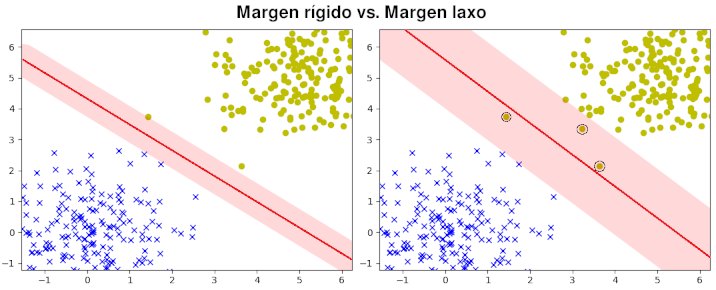

Los márgenes laxos introducen una variable _**slack**_ $~\zeta^{(i)}~$ para cada ejemplo, $~i=1,2,\ldots,N;$ tal que:
- $\zeta^{(i)} = 0~$ si el ejemplo $~{\bf x}^{(i)}~$ está correctamente clasificado y fuera del margen,
- $0 < \zeta^{(i)} < 1~$ si el ejemplo $~{\bf x}^{(i)}~$ está correctamente clasificado PERO dentro del margen,
- $\zeta^{(i)} > 1~$ si el ejemplo $~{\bf x}^{(i)}~$ está mal clasificado.

Es decir, la restricción se convierte en:
$$
(y)\cdot(w_0 + w_1x_1 + w_2x_2) > 1-\zeta
$$
De esta manera $~\zeta~$ "afloja" la restricción cuando el resultado de $~(y)\cdot(w_0 + w_1x_1 + w_2x_2)~$ no llega a superar 1, bajándolo hasta $1-\zeta$.

|   |
|---|
| Algo <i>slack</i> es algo que no está apretado, que está aflojado |

Pero ADEMÁS hay que añadir todos los $~\zeta^{(i)}~$ al problema de minimización para penalizar aquellos que sean mayores que 0.

De esta manera llegamos a la formulación completa del problema de optimización de SVM

# Formulación dual



## Problema de optimización inicial

Comenzamos recopilando la función objetivo que queremos minimizar y las restricciones
$$
  \begin{array}{ll}
	\mathop {\min }\limits_{{\bf w},\zeta} &
	\frac{1}{2}{\bf w}^\top{\bf w}  +  C \sum\limits_{i=1}^{N} \zeta^{(i)}, \\
	 \text{sujeto a}  &
	 \left\lbrace
	   \begin{array}{l}
	    \left({y^{(i)}}~\right)\cdot(w_0 + w_1x_1 + w_2x_2) > 1-\zeta^{(i)}  \\
	    \zeta^{(i)} \ge 0  \\
	    i = 1,2,\ldots,N.
	   \end{array}
	 \right. \\
  \end{array}
$$

Para simplificar las expresiones dejaremos de escribir que las variables _slack_ son no-negativas y que $i$ son enteros desde 1 hasta $N$.

A continuación,
- reescribimos la restricción
$\quad \left({y^{(i)}}~\right)\cdot(w_0 + w_1x_1 + w_2x_2) -1 +\zeta^{(i)}  > 0 $
- generalizamos a $D$ características, y por tanto $~D+1~$ parámetros $~\{w_0, w_1, w_2, \ldots, w_D\}.~$ De esta manera:
	- el vector ${\bf w}=[w_1,\ldots,w_D]^\top$
	- la restricción se reescribe como
	  $~ \left({y^{(i)}}~\right)\cdot(w_0 + {\bf w}^\top{\bf x}) -1 +\zeta^{(i)}  > 0 $

<u>En definitiva</u>, el problema de optimización que se plantea para clasificadores SVM lineales es:
$$
  \begin{array}{ll}
	  \mathop {\min }\limits_{{\bf w},w_0,\zeta} &
	  \frac{1}{2}{\bf w}^\top{\bf w}  +  C \sum\limits_{i=1}^{N} \zeta^{(i)}, \\
	  \text{sujeto a}  & \left({y^{(i)}}~\right) \left(w_0+{\bf w}^\top{\bf x} \right) - 1 + \zeta^{(i)} \ge 0  
  \end{array}
$$

### Aplicación de Multiplicadores de Lagrange

Recordamos que este método consiste en añadir (restando) las restricciones a la función objetivo multiplicadas por un factor denominado "multiplicador de Lagrange".

Como $i=\{1,2,\ldots, N\}, ~$ tenemos $N$ restricciones (una por cada ejemplo de entrenamiento). De esta manera se obtiene el _Lagrangiano_:

$$ \mathcal L =
\frac{1}{2}{\bf w}^\top{\bf w} + C \sum\limits_{i=1}^{N}\zeta^{(i)}
-
\sum\limits_{i=1}^N \alpha_i\left((y^{(i)})(w_0+{\bf w}^\top {\bf x}^{(i)} ) – 1 + \zeta^{(i)}\right),
$$

donde $\alpha_i$ son los multiplicadores de Lagrange.

Así que buscamos los parámetros que minimizan el Lagrangiano, es decir
$~~
\mathop{\arg\min}\limits_{ {\bf w}, w_0, \zeta^{(i)} } \mathcal L.
$

Para localizar el mínimo derivamos respecto de las variables e igualamos a cero.

$$
\begin{align}
\frac{\partial \mathcal L}{ \partial {\bf w} } &= 0;\quad
   {\bf w} - \sum\nolimits_{i=1}^N \alpha_i y^{(i)} {\bf x}^{(i)} = 0;\quad
   {\bf w} = \sum\nolimits_{i=1}^N \alpha_i y^{(i)} {\bf x}^{(i)} \\[1em]
\frac{\partial \mathcal L}{ \partial w_0} &= 0;\quad
   \sum\nolimits_{i=1}^N \alpha_i y^{(i)} = 0;\quad \\[1em]
\frac{\partial \mathcal L}{ \partial \zeta^{(i)}} &= 0;\quad
   C - \alpha_i = 0.
\end{align}
$$
y sustituimos las igualdades resultantes en el Lagrangiano.

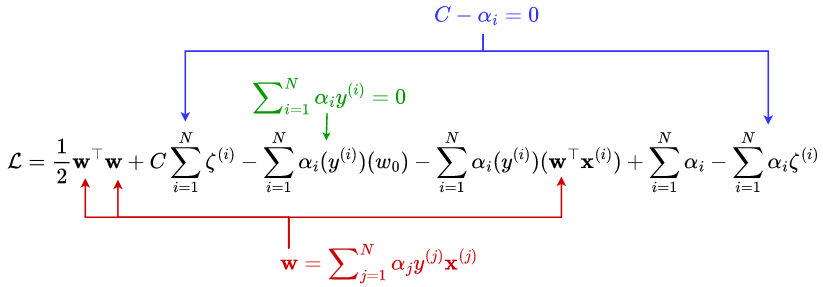

## Nuevo problema de optimización
En el método de multiplicadores de Lagrange ahora tenemos que maximizar respecto de cada $\alpha^{(i)}$; es decir
$$
  \mathop{\arg\max}\limits_{\alpha^{(i)}} \left(
  \sum_{i=1}^{m} \alpha^{(i)} -
	\frac{1}{2}\sum\limits_{i=1}^{N}\sum\limits_{j=1}^{N}\alpha^{(i)}\alpha^{(j)}y^{(i)}y^{(j)}{\bf x}^{(i)\top}{\bf x}^{(j)}  
  \right).
$$
La diferencia es que este problema ahora solo tiene como restricciones que los multiplicadores sean positivos o nulos. Además los multiplicadores son escalares mientras que en el problema orginal buscabamos el vector de parámetros.

Este problema es **mucho más** fácil de resolver ya que se puede atacar numéricamente con solución exacta.

Una vez resuelto se obtienen dos tipos de multplicadores:
$$
\left.\begin{array}{r}
\alpha = 0 \\
\alpha > 0
\end{array}
\right\rbrace
\rightarrow
\text{¿Qué pasa en cada caso?}
$$

Recordando que
$~{\bf w} = \sum\nolimits_{i=1}^N \alpha_i y^{(i)} {\bf x}^{(i)},~$
un $\alpha^{(i)} = 0~$ provoca que el ejemplo $i$-ésimo **NO CONTRIBUYA** al cálculo de los parámetros del modelo.

Por el contrario, los $\alpha^{(i)} > 0~$ indican aquellos ejemplos que **SÍ** se utilizan para el modelo.

Es decir, son los ejemplos que **SOPORTAN** la máquina, mientras que los demás no tienen ninguna importancia e incluso se podrían eliminar. <br>
<small>_De ahí el nombre de este modelo_.</small>

## Solución para el SVM lineal

El resumen de esta sección es que la máquina SVM lineal tiene como parámetros óptimos:

$$
\begin{align}
 	{\bf w}^* &= \sum_{i=1}^{N}\alpha^{*(i)}y^{(i)}{\bf x}^{(i)}
 	\hspace{1em},
\\
 	w_0^* &= \frac{1}{n_s} \sum_{i:\alpha^{*(i)}>0}\left( (1-y^{(i)})({\bf w}^{*\top}{\bf x}^{(i)})  \right),
\end{align}
$$

y, por supuesto, la noción de que los ejemplos asociados a un $\alpha^{(i)}>0$ son los **vectores soporte.**

# El truco del Kernel

Como ya vimos, un modo de hacer clasificación no lineal es transformar los vectores de características y después hacer clasificación lineal sobre los ejemplos transformados.

Es decir que aplicamos una función $\phi({\bf x})$ a cada vector y aplicamos un clasificador lineal al ejemplo mapeado por $\phi$; de tal modo que nuestro modelo "no lineal" es:
$$
f({\bf x};{\bf w^*},w_0) = w_0^* + {\bf w^*} ^\top \phi({\bf x})
$$

Entonces, cuando llegue un nuevo ejemplo $\bf z$ el resultado del modelo será
$$
\hat{y} = {\bf w}^{*\top} \color{blue}{\phi({\bf z})} + w_0^*
 =
\left( \sum_{i=1}^{N}\alpha^{*(i)}y^{(i)}\color{blue}{\phi({\bf x}^{(i)})} \right)^\top \color{blue}{\phi({\bf z})} + w_0^*
$$

Como $~y^{(i)}~$  y  $~\alpha^{(i)}~$ son escalares, el único vector es $\phi({\bf x}^{(i)})$, entonces:

$$
\begin{align}
\hat{y} &= \sum\limits_{i:\alpha^{*(i)}>0} \alpha^{*(i)}y^{(i)}
\color{blue}{\left( \phi({\bf x}^{(i)})^\top \phi({\bf z}) \right)} \\[1em]
&=
 \sum_{i:\alpha^{*(i)}>0}\alpha^{*(i)}y^{(i)}
 {\color{blue}{K({\bf x}^{(i)},{\bf z})}}  + w_0^*
\end{align}
$$

En la expresión anterior hemos sustituido el producto escalar $\phi({\bf x}^{(i)})^\top \phi({\bf z}) $ por la función $K({\bf x}^{(i)},{\bf z})$ llamada **_Kernel_**.

En otras palabras, el **_Kernel_** de dos vectores devuelve el producto escalar de los vectores mapeados a otro espacio mediante la función $\phi(\cdot)$.

En la última expresión aún queda por desarrollar el término $w_0^*$.
Nos ahorramos la manipulación, y vamos directos a la expresión final
$$
w_0^* = \frac{1}{n_s}
 \sum_{i:\alpha^{*(i)}>0}\left( \left(1-y^{(i)}\right) \sum_{j:\alpha^{*(j)}>0} \left( \alpha^{*(j)} y^{(j)} {\color{blue}{K({\bf x}^{(j)},{\bf z})}} \right)  \right),
$$
donde $n_s$ es el número de multiplicadores mayores que 0.

En definitiva, la predicción depende del Kernel y de los vectores soporte completamente.


# Pérdida _Hinge_

SVM da lugar a una función de pérdida llamada _Hinge_ ("Bisagra").

La restricción del márgen laxo se puede incorporar a la función que queremos minimizar, es decir la norma-2 del vector de parámetros, mediante el término
$$
\max\big(0,~~1-y\cdot f({\bf w}^\top{\bf x})\big).
$$
- Si $~0 < f({\bf w}^\top{\bf x}) < 1 ~$ y el ejemplo tiene $~y=+1~$ entonces el ejemplo está bien clasificado PERO dentro del margen y por tanto penaliza<br>
- Si $~f({\bf w}^\top{\bf x}) > 1 ~$ y el ejemplo tiene $~y=+1~$ entonces bien clasificado PERO fuera del margen y por tanto el término es 0.
- Lo mismo se puede decir para el caso en el que el ejemplo sea de la clase  $~y=-1~$

En definitiva, la pérdida _Hinge_ es:
$$ \mathcal L_{\text Hinge} = \max\big(0,~~1-y\cdot f({\bf w}^\top{\bf x})\big) + \frac{1}{2}\Vert{\bf w}\Vert^2$$


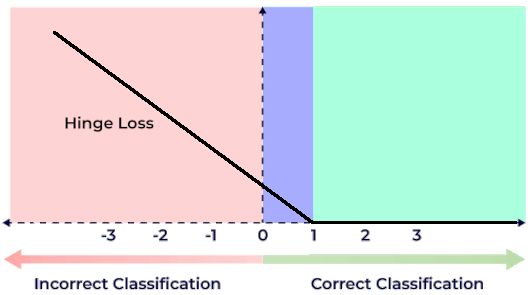

<hr>

# Resumen

- SVM es un modelo lineal que trata de minimizar el número de ejemplos dentro del margen, al mismo tiempo que intenta maximizar dicho margen.
  - Maximizar el márgen se consigue minimizando la norma-2 del vector de parámetros del modelo.
  - Minimizar el número de ejemplos se controla con la constante $C$ que acompaña al sumatorio de las variables _slack_.
    - Si $C$ es "pequeña" entonces ese sumatorio tiene poca importancia en el problema de minimización y por tanto podemos aumentar el margen. <br>
    Los errores que cometamos tendrán $\zeta >0$ pero $C$ reduce su contribución.
    - Si $C$ es "grande" entonces la contribución de los errores que cometamos se ve aumentada.<br>
    Por tanto el optimizador reducirá la norma-2 del vector de parámetros para compensar.
- El problema de optimización que se plantea es cuadrático con restricciones y se resuelve aplicando los multiplicadores de Lagrange.
  - De esta manera las restricciones se añaden a la función de pérdida.
  - Como hay una restricción por cada ejemplo, se añaden $N$ términos a la pérdida.
- Al resolver el problema _dual_ averiguamos que algunos multiplicadores son positivos y distintos de cero. <br>
$\rightarrow$ Los ejemplos que tienen el mismo $i$ que los multiplicadores $\alpha_i > 0$ son los vectores soporte.
- Para obtener SVM NO-lineal utilizamos un **kernel** que sustituye el producto escalar de un vector soporte con el vector del que queremos estimar su valor objetivo.
  - Nos hemos librado de tener que elegir una función $\phi(\cdot)$, pero ahora tenemos que elegir un Kernel. <br> Simplemente por información, algunos son:

| _Kernel_ |  $K({x},{z}) = $  | Hiperparámetros |
|:----|:----|:----:|
|Lineal | ${\bf x}^\top{\bf z}$ | no tiene |
|Polinómico | $\left(\gamma {\bf x}^\top{\bf z} + r \right)^d$ | $\gamma$, $r$, $d$ |
| Sigmoide | $\tanh \left( \gamma {\bf x}^\top{\bf z} + r \right)$ | $\gamma$, $r$ |
| Radial Basis Function (RBF) | $\exp\left(-\gamma \|{\bf x}-{\bf z}\|^2 \right) $  | $\gamma$ |

Además se introduce la pérdida _Hinge_ como alternativa a la formulación del SVM lineal.<br>
Esta pérdida reduce la manipulación matemática PERO sin ella no aparece la posibilidad de aplicar Kernels.